<a href="https://colab.research.google.com/github/Carvas91/PyTroch/blob/main/Animal_faces_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: carvas91
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 206MB/s]


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
img_path = []
labels = []

for i in os.listdir('/content/animal-faces/afhq'):
  for label in os.listdir(f'/content/animal-faces/afhq/{i}'):
    for img in os.listdir(f'/content/animal-faces/afhq/{i}/{label}'):
      img_path.append(f'/content/animal-faces/afhq/{i}/{label}/{img}')
      labels.append(label)





In [5]:
df = pd.DataFrame(zip(img_path,labels), columns=["image_path",'labels'])

In [6]:
df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/wild/flickr_w...,wild
1,/content/animal-faces/afhq/train/wild/flickr_w...,wild
2,/content/animal-faces/afhq/train/wild/pixabay_...,wild
3,/content/animal-faces/afhq/train/wild/flickr_w...,wild
4,/content/animal-faces/afhq/train/wild/flickr_w...,wild


In [7]:
df.labels.value_counts()

,count
labels,
cat,5653
dog,5239
wild,5238


In [8]:
train = df.sample(frac=.7)
test = df.drop(index=train.index)
val = test.sample(frac=.5)
test = test.drop(val.index)


print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(df.labels)



transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

In [10]:
class CustomImgDataset(Dataset):
  def __init__(self, df, transform=None):
    super().__init__()
    self.dataframe = df
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(df.labels),device=device)
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, index):
    img_path = self.dataframe.iloc[index,0]
    label = self.labels[index]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image).to(device)
    return image, label



In [11]:
train_dataset = CustomImgDataset(train, transform)
val_dataset = CustomImgDataset(val, transform)
test_dataset = CustomImgDataset(test, transform)

In [12]:
label_encoder.inverse_transform([0,1,2])

array(['cat', 'dog', 'wild'], dtype=object)

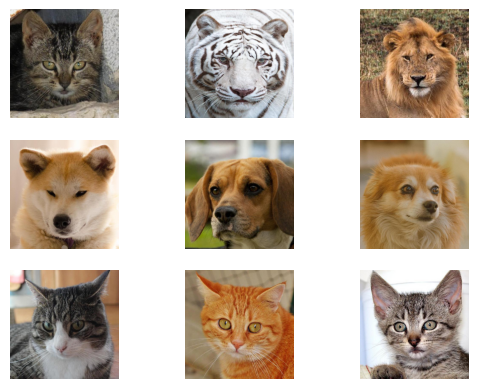

In [13]:
n_rows= 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(1)["image_path"].iloc[0]).convert('RGB')
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')


In [14]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [15]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [16]:
# Define a custom neural network class inheriting from nn.Module, the base class for all PyTorch models
# The class' name is "Net"
class Net(nn.Module):
  def __init__(self):
    super().__init__()  # Calls the parent nn.Module's constructor to initialize model internals

    # First convolutional layer: input = 3 channels (Red, Green, Blue), output = 32 feature maps
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 3x3 kernel captures local features; padding=1 preserves input height/width after conv

    # Second convolutional layer: input = 32, output = 64 feature maps
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

    # Third convolutional layer: input = 64, output = 128 feature maps
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    # Max pooling to downsample the feature maps (2x2 window)
    self.pooling = nn.MaxPool2d(2, 2)

    # ReLU activation function. The ReLU activation adds non-linearity by zeroing out negative values; helps model learn complex patterns
    self.relu = nn.ReLU()

    # Converts 3D feature maps into 1D vectors required by linear layers (the next step in the forward pass)
    self.flatten = nn.Flatten()

    # Fully connected layer: input = 128*16*16 (after conv + pooling), output = 128
    self.linear = nn.Linear(128 * 16 * 16, 128) # Converts 128 feature maps of size 16x16 into a 32768-element vector for the dense layer

    # Output layer: number of output neurons = number of unique labels (3 classes in this case)
    self.output = nn.Linear(128, len(df.labels.unique()))

  def forward(self, x):#This method defines the forward pass of the neural network
    # Pass input through conv1 -> pooling -> ReLU
    x = self.conv1(x) #The input x is passed through the first convolutional layer.
    x = self.pooling(x) #The output of the convolutional layer is then passed through the max pooling layer.
    x = self.relu(x) #The output of the pooling layer is passed through the ReLU activation function.

    # Pass through conv2 -> pooling -> ReLU
    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)

    # Pass through conv3 -> pooling -> ReLU
    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)

    # Flatten for linear layers
    x = self.flatten(x) # After the final convolutional and pooling layers, the output is flattened into a 1D vector.

    # Pass through dense layer
    x = self.linear(x)

    # Output prediction
    x = self.output(x)

    return x # the model's predictions for each input image

In [17]:
model = Net().to(device)

In [18]:
from torchsummary import summary
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [25]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  model.train()
  for X, y in train_loader:
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    total_loss_train += loss.item()
    total_acc_train += (outputs.argmax(1) == y).sum().item()

  model.eval()
  with torch.no_grad():
    for X, y in val_loader:
      outputs = model(X)
      loss = criterion(outputs, y)
      total_loss_val += loss.item()
      total_acc_val += (outputs.argmax(1) == y).sum().item()

  avg_train_loss = round(total_loss_train / len(train_loader.dataset), 4)
  avg_val_loss = round(total_loss_val / len(val_loader.dataset), 4)
  train_acc = round(total_acc_train / len(train_loader.dataset) * 100, 4)
  val_acc = round(total_acc_val / len(val_loader.dataset) * 100, 4)

  total_loss_train_plot.append(avg_train_loss)
  total_loss_val_plot.append(avg_val_loss)
  total_acc_train_plot.append(train_acc)
  total_acc_val_plot.append(val_acc)

  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss}, Train Acc: {train_acc}%, Val Loss: {avg_val_loss}, Val Acc: {val_acc}%")


Epoch 1/10, Train Loss: 0.0114, Train Acc: 93.4373%, Val Loss: 0.0111, Val Acc: 93.6364%
Epoch 2/10, Train Loss: 0.008, Train Acc: 95.4034%, Val Loss: 0.0081, Val Acc: 95.8678%
Epoch 3/10, Train Loss: 0.0058, Train Acc: 96.6965%, Val Loss: 0.008, Val Acc: 95.2479%
Epoch 4/10, Train Loss: 0.0042, Train Acc: 97.6884%, Val Loss: 0.0081, Val Acc: 95.5785%
Epoch 5/10, Train Loss: 0.0032, Train Acc: 98.211%, Val Loss: 0.0082, Val Acc: 95.6198%
Epoch 6/10, Train Loss: 0.0024, Train Acc: 98.6627%, Val Loss: 0.0073, Val Acc: 96.4463%
Epoch 7/10, Train Loss: 0.0017, Train Acc: 98.9815%, Val Loss: 0.009, Val Acc: 95.2066%
Epoch 8/10, Train Loss: 0.0015, Train Acc: 99.2649%, Val Loss: 0.0101, Val Acc: 95.3306%
Epoch 9/10, Train Loss: 0.0009, Train Acc: 99.6015%, Val Loss: 0.0083, Val Acc: 96.1157%
Epoch 10/10, Train Loss: 0.0007, Train Acc: 99.6723%, Val Loss: 0.0094, Val Acc: 96.1157%


In [26]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for X, y in test_loader:
    pred = model(X)
    test_loss = criterion(pred, y)
    total_loss_test += test_loss.item()
    test_acc = (pred.argmax(1) == y).sum().item()
    total_acc_test += test_acc

  avg_test_loss = total_loss_test / len(test_loader.dataset)
  test_accuracy = total_acc_test / len(test_loader.dataset) * 100

  print(f"Test Acc: {round(test_accuracy, 4)}% | Loss: {round(avg_test_loss, 4)}")



Test Acc: 95.6594% | Loss: 0.0099


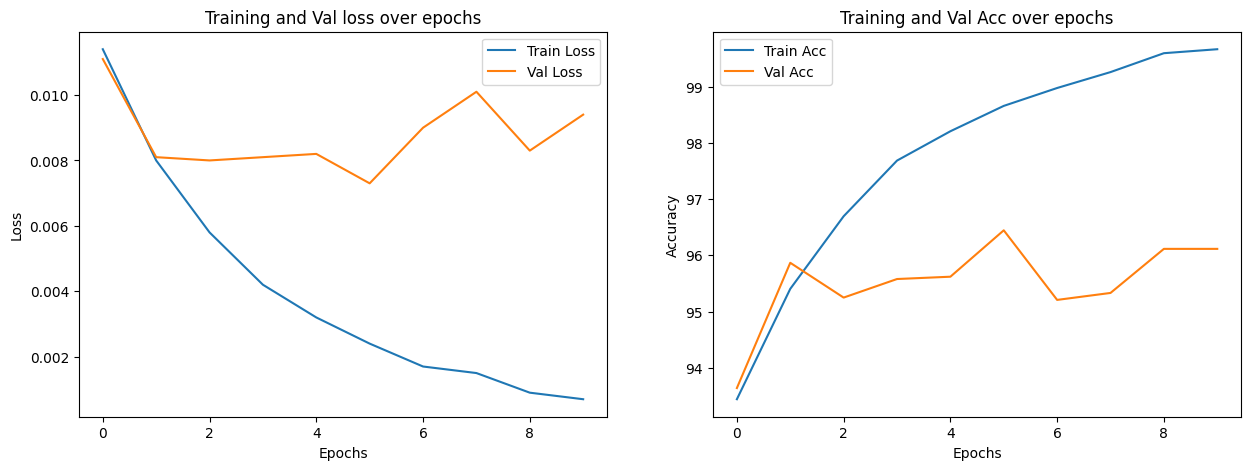

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_val_plot, label='Val Loss')
axs[0].set_title("Training and Val loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Acc")
axs[1].plot(total_acc_val_plot, label='Val Acc')
axs[1].set_title("Training and Val Acc over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()
